In [30]:
using CSV, DataFrames, Distributions,StatsBase, PythonPlot, LinearAlgebra, DifferentialEquations
using Turing
include("./../simulation_models.jl")


build_model (generic function with 1 method)

## Load experimental data (Gaussian process output)

In [41]:
NSF_CAREER_PATH = "/Users/elevien/Dartmouth College Dropbox/Ethan Levien/PROPOSALS/NSFCareer2024/figures/growth_dynamics"

df_all = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);
lineages = unique(df_all.lineage);

In [40]:
preds = []
params = []
pred_dir = "./../output/output_7-24-24"
files = readdir(pred_dir)
for f in files
    df = CSV.read(pred_dir*"/"*f*"/preds.csv",DataFrame)
    ag(t) = round.(t .- t[1],digits=2)
    df = combine(groupby(df,:position),:time => ag => :age,names(df))
    push!(preds,df)
    push!(params,CSV.read(pred_dir*"/"*f*"/opt_params.csv",DataFrame))
end

## Testing making experimental data for loss function (WIP)

In [127]:
# parameter values
λ0 = 0.05
init = [40,λ0,80,0]
σ_gr = sqrt(1.32e-4)
τ = 1
D = σ_gr^2/τ
σDS = 0.0005
Δ = 40
σM = sqrt(50)

7.0710678118654755

In [128]:
df_data = preds[2]; # we will work with one lineage at a time
dt_data = mean(diff(df_data.time))




θ = [Δ,σDS,τ,λ0,D,σM] 
prob,callback = build_model(θ,init,(0,400))
@time sol = solve(prob,callback = callback,saveat=df_data.time,adaptive =true,dt=0.0001)
u = hcat(sol.u...)';


  0.004887 seconds (55.84 k allocations: 1021.906 KiB)


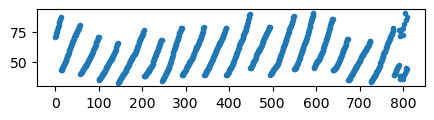

In [135]:
fig, ax= subplots(figsize=(5,1))
ax.plot(u[90:end,1],".")
fig

# MSD Analysis setup

In [188]:
function msd_withinbetween(u,lag)
    """
    Takes as input an array whose first column is 
    the growth rates and second is the position
    returns MSD within and between
    """
    δ = (u[1:end-lag,1] .- u[lag:end-1,1]).^2
    is_within = (u[1:end-lag,2] .== u[lag+1:end,2])
    δ_within = δ[is_within .== 1]
    δ_between = δ[is_within .== 0]
    return [mean(δ_within),mean(δ_between)]
end


function msd_lineage(df,x,lag)
    x_data = Array(df[:,[x,:position]]);
    M = hcat([msd_withinbetween(x_data,l) for l in 1:1:50]...)'
end 


function msd_lineage_ratio_avg(df,x,lag)
    M = msd_lineage(df,x,lag)
    mw = M[:,1]
    mb = M[:,2]
    r = mw ./ (mb .+ mw)
    mean(filter(!isnan,r))
end

function msd_lineage_avg_ratio(df,x,lag)
    M = msd_lineage(df,x,lag)
    mw =filter(!isnan,M[:,1])
    mb = filter(!isnan,M[:,2])
    r = mean(mw) ./ (mean(mb) .+ mean(mw))
end 

msd_lineage_avg_ratio (generic function with 1 method)

## One lineage

First I'm looking at one lineage and computing the 

In [181]:
df_data = preds[2]; # we will work with one lineage at a time
dt_data = mean(diff(df_data.time))

x_data = Array(df_data[:,[:matern32_flucs_x,:position]]);
x_sims = u[:,[2,4]];

lag =4
M = hcat([msd_withinbetween(x_sims,l) for l in 1:1:50]...)'
M_data = hcat([msd_withinbetween(x_data,l) for l in 1:1:50]...)';


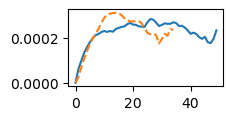

In [182]:

fig, ax = subplots(figsize=(2,1))

ax.plot(M[:,1],"-")
#ax2 = ax.twinx()
ax.plot(2M_data[:,1],"--")
#ax.set_ylim([0,2])
fig

# All lineage

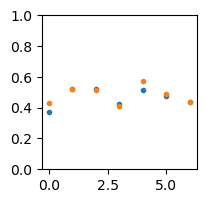

In [189]:
fig,ax = subplots(figsize=(2,2))
ax.plot([msd_lineage_ratio_avg(df,:matern32_flucs_x,40) for df in preds],".")
ax.plot([msd_lineage_avg_ratio(df,:matern32_flucs_x,40) for df in preds],".")

ax.set_ylim([0,1])
fig

# Misc

In [39]:


ens = EnsembleProblem(prob)
sol = solve(ensembleprob, SOSRI(), saveat = 0.1, trajectories = 10_000)
truemean = mean(sol, dims = 3)[:, :]
truevar = var(sol, dims = 3)[:, :]

UndefVarError: UndefVarError: `ensembleprob` not defined